Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import seaborn as sns
from IPython.display import display
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score, roc_auc_score, auc, roc_curve
import wget
import warnings
warnings.filterwarnings('ignore')

Loading Data

In [2]:
#name = "credit_card_data.csv"
#wget.download('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv', name)

In [3]:
data = pd.read_csv('C:/Users/Godwin/Documents/Workflow/ML Zoomcamp/Evaluation Metrics/credit_card_data.csv')
data.head()

Data Preparation

In [4]:
#card = data.pop('card')
data['card'] = (data['card'] == 'yes').astype('int')
#data.head()

Split Data For Training

In [25]:
train_df, test_df = train_test_split(data, test_size = 0.2, random_state = 1)
train_df, val_df = train_test_split(train_df, test_size = 0.25, random_state = 1)

y_train = train_df.pop('card')
y_test = test_df.pop('card')
y_val = val_df.pop('card')

numerical_col = train_df.dtypes[train_df.dtypes != 'object'].index.tolist()

Question 1

Which numerical variable (among the following 4) has the highest AUC?

In [9]:
df = train_df.copy()
scores = []
for i in numerical_col:
    auc = roc_auc_score(y_train, df[i])

    if auc < 0.5:
        auc = roc_auc_score(y_train, -df[i])
    scores.append(auc)

dicts = {"Column": numerical_col, 'Auc Score': scores}
outs = pd.DataFrame(dicts)
outs

,Column,Auc Score
0,reports,0.716663
1,age,0.524002
2,income,0.590805
3,share,0.989184
4,expenditure,0.991042
5,dependents,0.532776
6,months,0.529422
7,majorcards,0.534386
8,active,0.604317


From the given options the share column has the highest auc_score



Encoding The Data

In [26]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

dv = DictVectorizer(sparse = False)
dv.fit(train_df[columns].to_dict(orient= 'records'))
names = dv.get_feature_names()

X_train = dv.transform(train_df[columns].to_dict(orient= 'records'))
X_test = dv.transform(test_df[columns].to_dict(orient = 'records'))
X_val = dv.transform(val_df[columns].to_dict(orient = 'records'))

Question 2

What's the AUC of this model on the validation dataset?

In [28]:
#MOdel 
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

#Validating the model
prediction = model.predict_proba(X_val)[:,1]
roc_auc_score(y_val, (prediction >= 0.5).astype('int'))

0.9739783600107306

Question 3

Computing Precision And Recall

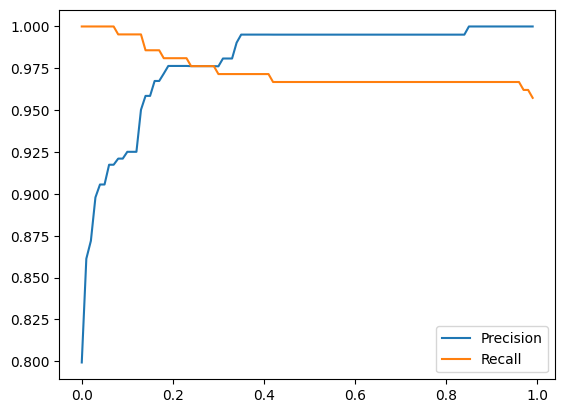

In [19]:
threshold = np.arange(0,1 ,step = 0.01)
precision_values = []
recall_values = []

for t in threshold:
        
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predicted_positive = (prediction >= t)
    predicted_negative = (prediction < t)



    tp = (actual_positive & predicted_positive).sum()
    tn = (actual_negative & predicted_negative).sum()
    fp = (actual_negative & predicted_positive).sum()
    fn = (actual_positive & predicted_negative).sum()

    precision = tp/(tp + fp)
    recall = tp/(tp +fn)

    precision_values.append(precision)
    recall_values.append(recall)

#Plotting Values
plt.plot(threshold, precision_values, label = 'Precision')
plt.plot(threshold, recall_values, label = 'Recall')
plt.legend()

Question 4

Computing F1_Score

In [29]:
threshold = np.arange(0,1 ,step = 0.01)
f1_values = []
for t in threshold:
        
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predicted_positive = (prediction >= t)
    predicted_negative = (prediction < t)



    tp = (actual_positive & predicted_positive).sum()
    tn = (actual_negative & predicted_negative).sum()
    fp = (actual_negative & predicted_positive).sum()
    fn = (actual_positive & predicted_negative).sum()

    precision = tp/(tp + fp)
    recall = tp/(tp +fn)


    f1 = 2 * ((precision * recall)/ (precision + recall))
    f1_values.append(f1)
out = pd.DataFrame({'Threshold':threshold, 'F1_score':f1_values})

#Returning Threhold with the highest F1 score
out[out['F1_score'] == out['F1_score'].max()]

,Threshold,F1_score
35,0.35,0.983213
36,0.36,0.983213
37,0.37,0.983213
38,0.38,0.983213
39,0.39,0.983213
40,0.40,0.983213
41,0.41,0.983213


Question 5

Using cross validation evaluation metic

In [30]:
full_df = pd.concat([train_df, val_df])
full_df['label'] = pd.concat([y_train, y_val])

kfolds = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for train_idx, val_idx in kfolds.split(full_df):

    train_df = full_df.iloc[train_idx]
    val_df = full_df.iloc[val_idx]

    y_train = train_df.pop('label')
    y_val = val_df.pop('label')

    dv.fit(train_df.to_dict(orient = 'records'))
    X_train = dv.transform(train_df.to_dict(orient = 'records'))
    X_val = dv.transform(val_df.to_dict(orient = 'records'))

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    prediction = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val,prediction)
    scores.append(score)

#Computing standard deviation for the all the splits
np.std(scores)

0.005280277859810096

Question 6

Finding the best parameter C with cross validation

In [24]:
full_df = pd.concat([train_df, val_df])
full_df['label'] = pd.concat([y_train, y_val])

kfolds = KFold(n_splits=5, shuffle=True, random_state=1)

c_values = [0.01, 0.1, 1, 10]
auc_scores = []
stds = []
for c in c_values:

    scores = []
    for train_idx, val_idx in kfolds.split(full_df):

        train_data = full_df.iloc[train_idx]
        val_data = full_df.iloc[val_idx]

        y_train = train_data.pop('label')
        y_val = val_data.pop('label')

        dv.fit(train_data.to_dict(orient = 'records'))
        X_train = dv.transform(train_data.to_dict(orient = 'records'))
        X_val = dv.transform(val_data.to_dict(orient = 'records'))

        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train, y_train)
        prediction = model.predict_proba(X_val)[:,1]
        score = roc_auc_score(y_val,prediction)
        scores.append(score)
    auc_scores.append(round(np.mean(scores),3))
    stds.append(round(np.std(scores)))
   

dicts = {"C Values": c_values, "Mean Value": auc_scores, 'Standard Deviation': stds}
output = pd.DataFrame(dicts)
output

,C Values,Mean Value,Standard Deviation
0,0.01,0.991,0
1,0.10,0.994,0
2,1.00,0.996,0
3,10.00,0.996,0
